# Torch Audio Data Augmentation
The goal of this repo is to reproduce some common audio effects in pytorch for the purpose of audio data augmentation. This could be useful to train an audio classifier to ignore effects like reverb, compression, gain, etc. when classifying audio. With this purpose in mind, these effects are not aimed at producing stellar audio quality, instead prioritizing matrix operations and simplicity.  Examples of this include the compressor having no attack/release times.

In [1]:
import torchaudio
from fastai import *
from fastai.vision import *
from fastai_audio import *
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
import librosa
from librosa import display
import os, random

In [3]:
DATA = Path('./audio/')
TRAIN = DATA/"audio_train/"
TEST = DATA/"audio_test/"

In [204]:
fname = random.choice(os.listdir(TEST))
f = torchaudio.load(TEST/fname)
audio = f[0]
sr = f[1]

In [205]:
def show_wave(sound):
    plt.figure(1)
    plt.title("Waveform")
    plt.plot(sound[0,:])
    plt.show()

In [206]:
def show_spec(audio):
    X = librosa.stft(audio[0,:].numpy(), n_fft=2048, hop_length=512)
    S = librosa.amplitude_to_db(abs(X))
    S = librosa.feature.melspectrogram(S=S)
    librosa.display.specshow(S)

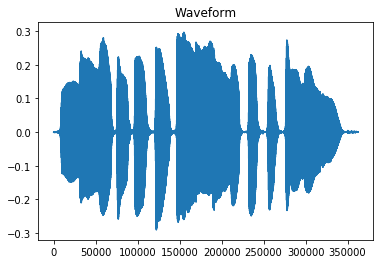

In [207]:
show_wave(audio)

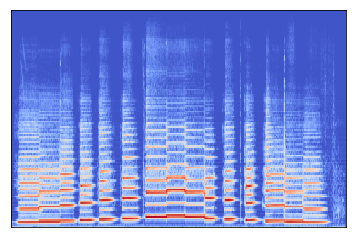

In [208]:
show_spec(audio)

In [209]:
def delay(audio, sr=44100, delays=[30, 100, 200], amps=[0.8, 0.5, 0.2]):
    """
    Adds delay effect to audio
    Note:
        delays must be same length as amps
    Arguments:
        audio (tensor): Audio signal as torch.tensor
        delays (list): Delays in ms
        amps (list): Amplitudes of delayed copies
    """
    delayss = [int(delay * sr / 1000) for delay in delays]
    print(delayss)
    delay_chan = torch.zeros(1, audio.size()[1])
    for i in range(len(delays)):
        delay = delayss[i]
        amp = amps[i]
        delsamps = torch.zeros(1, audio.size()[1])
        delsamps[:,delay:] = audio[:,0:-delay]*amps[i]
        delay_chan += delsamps
    return delay_chan + audio

[1323, 4410, 8820]


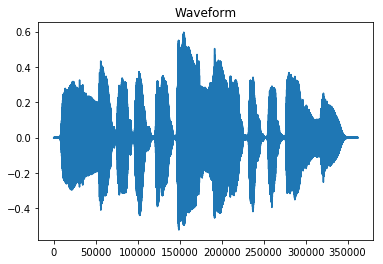

In [210]:
show_wave(delay(audio, sr, [30, 100, 200], [1, 0.5, 0.1]))

[11025, 22050, 33075, 44100]


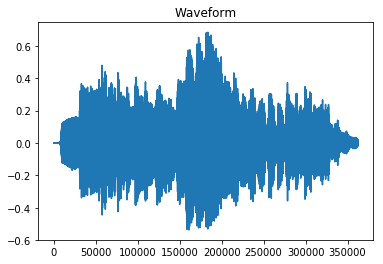

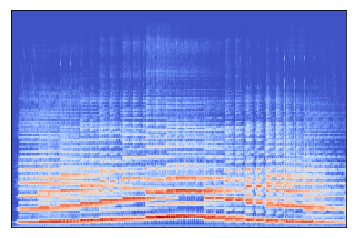

In [211]:
delayed = delay(audio, sr, [250, 500, 750, 1000], [1, 0.5, 0.25, 0.125])
show_wave(delayed)
show_spec(delayed)
ipd.Audio(delayed, rate=sr)

## Reverb

In [212]:
def reverb(audio, sr=44100, delay=20, decay=0.5):
    """
    Simple Reverb Delay Line
    Params:
        audio (torch.tensor): Audio Samples
        sr: sample rate
        delay: pre-delay and time between copies (ms)
        decay: how fast copies of the signal decay
    """
    delays = [127, 179, 233, 183]
    weights = [0.2, 0.5, 0.3, 0.2]
    delaysamps = [int(d * sr / 1000) for d in delays]
    alen = audio.size()[1]
    a = torch.clone(audio)
    for i in range(0, alen-max(delaysamps)):
        for j in range(len(delaysamps)):
            newvals = torch.zeros(len(delays), audio.size()[1])
            newvals = [a[:,i]*decay*weights[idx] for idx in range(len(weights))]
            a[:,i+delaysamps[j]] += a[:,i]*decay*weights[j]
    return a

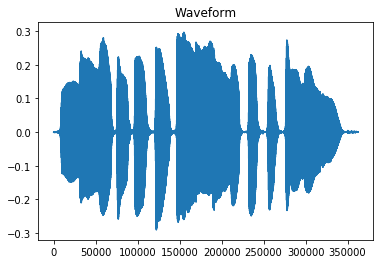

In [213]:
show_wave(audio)

In [214]:
show_wave(reverb(audio, sr, 50, 0.6))

KeyboardInterrupt: 

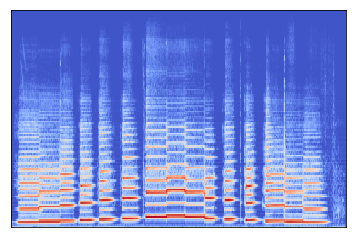

In [215]:
show_spec(audio)
ipd.Audio(audio, rate=sr)

In [216]:
rev = reverb(audio, sr, 100, 0.6)
show_spec(rev)
ipd.Audio(rev, rate=sr)

KeyboardInterrupt: 

# Gain

In [217]:
def gain(audio, sr=44100, g=1.0):
    return audio*g

In [218]:
audio

tensor([[-0.0005, -0.0004, -0.0003,  ...,  0.0000,  0.0000,  0.0000]])

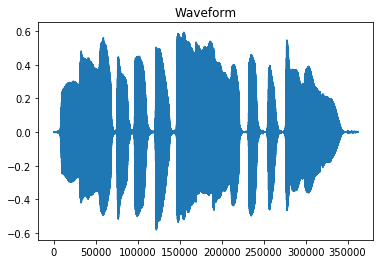

In [219]:
show_wave(gain(audio, sr, 2.0))

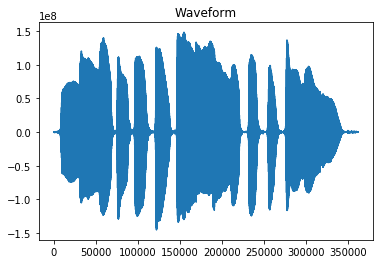

In [224]:
show_wave(gain(audio, sr, 5e8))

# Dynamics

In [225]:
def dynamics(audio, sr=44100, kind="compressor", thresh=0.5, ratio=4.0):
    """
    Dynamic processing, no time dependence is the goal here. Obviously this
    will lead to some unavoidable harmonic distortion, but to a limited degree
    this reflects what might happen in the real world.
    """
    num_thresh = thresh * max(audio[0])
    print(num_thresh)
    if kind == "compressor":
        comped = torch.ones(1, audio.size(1))
        for idx in range(audio.size(1)):
            samp = audio[0,idx]
            above_thresh = (abs(samp) - num_thresh) / ratio
            comped[0,idx] = samp if abs(samp) < num_thresh else abs(samp)/samp * (num_thresh + above_thresh)
        return comped

In [226]:
comped = dynamics(audio, sr, thresh=0.5, ratio=10)

tensor(0.1482)


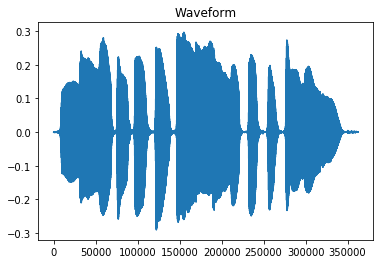

In [227]:
show_wave(audio)

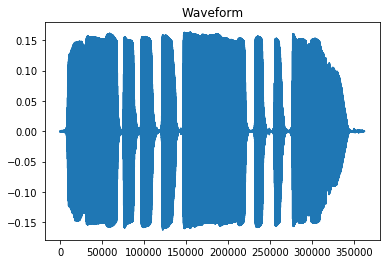

In [228]:
show_wave(comped)

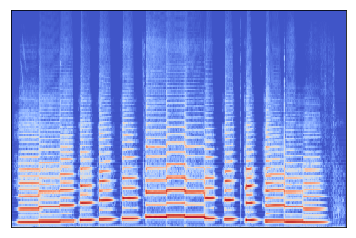

In [229]:
show_spec(comped)

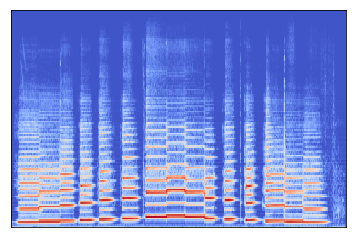

In [230]:
show_spec(audio)